# Pipelines in scikit-learn

Pipelines encapsualted in `sklearn.pipeline.Pipeline` allow us to sequentially apply a list of trasformations, followed by a final estimator on our data. Each intermediate steps implements a fit and transform method, while the final estimator has a fit method. This allows us to chain fitting of all transformations using a single fitting on the dataset. 

```{figure} ../img/pipelines.png
---
width: 45em
name: pipelines
---
Pipelines allow us to cleanly separate declarative from imperative code. [[source]](https://gh.mltrainings.ru/presentations/LopuhinJankiewicz_KaggleMercari.pdf)
```


From the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), the purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. But as shown in the above figure, pipelines also allow us to organize our code. This makes it easier to write, debug, and maintain our code. We will be using the Median House Price Prediction dataset following Chapter 2 of {cite}`geron2019hands-on` to demonstrate how to use pipelines in scikit-learn.


## House Prices Dataset

Our task is to use California census data to build a model of housing prices. This data includes metrics such as the population, median income, and median housing price for each district in California. We will use MAPE as our evaluation metric.

### Downloading the dataset

We download the data using the `request.urlretrieve` function from `urllib`. This function takes a URL where the data is hosted and a save path where the data will be stored on the local disk.

In [1]:
import pandas as pd
import numpy as np
import warnings
import os
import matplotlib.pyplot as plt
import tarfile
import urllib.request
from pathlib import Path

warnings.filterwarnings("ignore")
%matplotlib inline


def fetch_housing_data(housing_url, housing_path):
    '''Download data from `housing_url` and save it to `housing_path`.'''
    
    # Make directory
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    
    # Download data in housing_url to tgz_path
    urllib.request.urlretrieve(housing_url, tgz_path)
    
    # Extract tar file
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

Downloading...

In [2]:
# Dataset URL
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# Local save path
DATA_DIR = Path().resolve().parents[1] / 'data'
HOUSING_PATH = DATA_DIR / "housing"

# Downloading the data
fetch_housing_data(HOUSING_URL, HOUSING_PATH)

### Quick look at the data

Let us load the data using pandas.

In [3]:
housing = pd.read_csv(HOUSING_PATH / "housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.shape

(20640, 10)

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The feature `total_bedrooms` is sometimes missing. All features are numerical except `ocean_proximity` which is text.

In [6]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

The following plot shows how median house value is generally higher near the ocean. Moreover, prices seem to depend on population density.

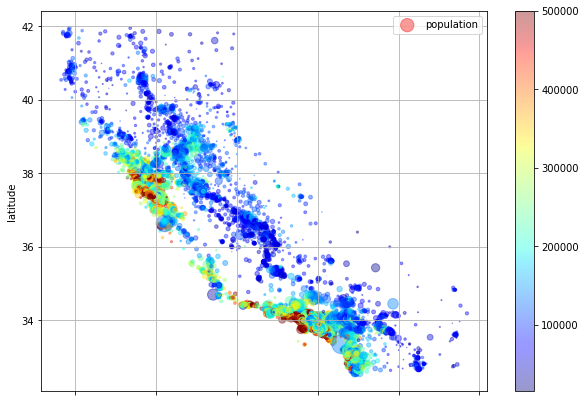

In [7]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c=housing["median_house_value"], cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()
plt.grid();

Let us look at the statistics of numerical features:

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


We can better visualize this table using histograms.

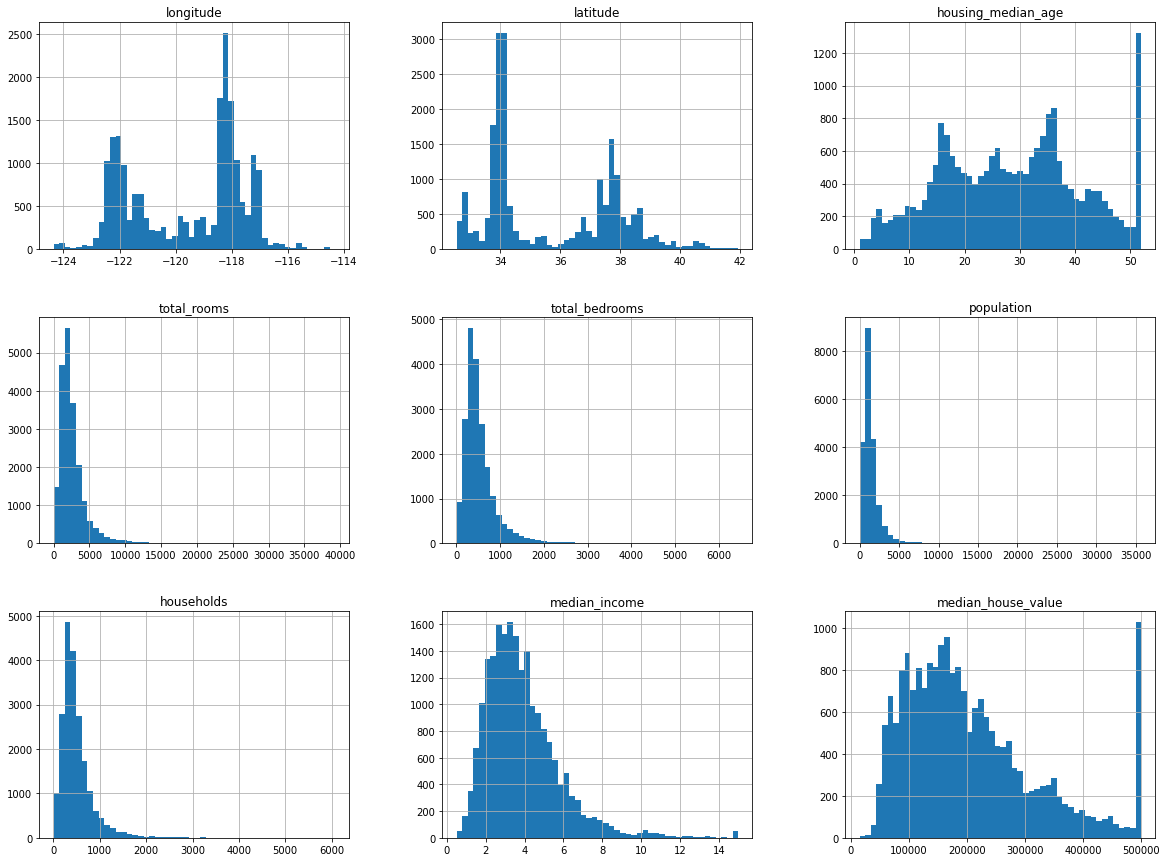

In [9]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

Distributions are tail-heavy; transforming the data to make it more bell-shaped may help some algorithms. Housing median age and house prices are capped.

### Getting a stratified test set

Suppose we know that median income is a very
important attribute to predict median housing prices. So we perform **stratified sampling** based on income categories to ensure that the test set is representative of the various categories of incomes in the whole dataset. 

We check the percentage error based on the `income_cat` distribution of the whole dataset.

In [10]:
from sklearn.model_selection import train_test_split

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# (Test dist - all dist) / all dist
uniform_error = (test_set['income_cat'].value_counts(normalize=True) - housing["income_cat"].value_counts(normalize=True))
uniform_error / housing["income_cat"].value_counts(normalize=True)

3    0.022664
2    0.017323
4   -0.050563
5   -0.043184
1    0.009732
Name: income_cat, dtype: float64

In [11]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, random_state=42, stratify=housing['income_cat'])

# (Strat test dist - all dist) / all dist
strat_error = strat_test_set['income_cat'].value_counts(normalize=True) - housing["income_cat"].value_counts(normalize=True)
strat_error / housing["income_cat"].value_counts(normalize=True)

3   -0.000138
2   -0.000152
4    0.000275
5   -0.000847
1    0.003650
Name: income_cat, dtype: float64

This looks way better. Let's drop the temporary indicator feature `income_cat` from the train and test sets.

In [12]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Preprocessing pipeline

In this section we create two pipelines for separate preprocessing of categorical and numerical data. These two pipelines will be combined in a single full preprocessing pipeline for the training data.

Revert back to the original stratified train set:

In [13]:
housing = strat_train_set.drop("median_house_value", axis=1)
targets = strat_train_set["median_house_value"].copy()

### Cleaning missing data

We separate processing of numerical and categorical variables, then perform median imputation on numerical features.

In [14]:
from sklearn.impute import SimpleImputer

housing_num = housing[[f for f in housing.columns if f != 'ocean_proximity']]
housing_cat = housing[['ocean_proximity']]

# Fitting the imputer on numerical fetures
imputer = SimpleImputer(strategy='median')
imputer.fit(housing_num)

# Checking...
(imputer.statistics_ == housing_num.median().values).all()

True

Finally, we check that there are no more null values in the datasets

In [15]:
housing_num_tr = pd.DataFrame(imputer.transform(housing_num), 
    columns=housing_num.columns, index=housing_num.index)

# Checking for nans
print(housing_num_tr.isna().sum().sum())
print(housing_cat.isna().sum().sum())

0
0


### Encoding categorical features

We perform **one-hot encoding** on the `ocean_proximity` feature. An alternative would be **ordinal encoding** whose order is based on the mean target value of the data conditioned on that categorical variable.

In [16]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_onehot = cat_encoder.fit_transform(housing_cat)

housing_cat_onehot # sparse

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [17]:
housing_cat_onehot.toarray() # dense

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [18]:
cat_encoder.categories_ # learned categories

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom transformers with `BaseEstimator` and `TransformerMixin`

Although scikit-learn provides many useful transformers, we will need to write own for tasks such as custom cleanup operations or combining specific
attributes. Custom transformers work seamlessly with existing scikit-learn functionalities such as `pipelines`, all we need to do is create a class and implement three methods: `fit()` that returns `self`, `transform()`, and `fit_transform()`.

We can get `fit_transform()` for free by simply adding `TransformerMixin` as a base class. If we add `BaseEstimator` as a base class, we will also get two extra methods, `get_params()` and `set_params()`, that will be useful for automatic hyperparameter tuning. (Make sure to have no `*args`, and `**kwargs` in the constructor.)

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

# Column indices
rooms_, bedrooms_, population_, households_ = 3, 4, 5, 6 


class CombinedFeaturesAdder(BaseEstimator, TransformerMixin):
    """Transformer for adding feature combinations discussed above."""
    
    def __init__(self, add_bedrooms_per_room=True): # No *args, **kwargs (!)
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_] / X[:, households_]
        population_per_household = X[:, population_] / X[:, households_]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_] / X[:, rooms_]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In this example the transformer has one hyperparameter, `add_bedrooms_per_room`,
set to `True` by default (it is often helpful to provide sensible defaults). This hyperparameter will allow us to easily find out whether adding this attribute helps the
ML algorithms or not. For now, we set this to `False`.

In [20]:
feature_adder = CombinedFeaturesAdder(add_bedrooms_per_room=False)
housing_extra_features = feature_adder.transform(housing.values)

Checking the shapes, the `feature_adder` should add two columns to the feature set.

In [21]:
housing.shape

(16512, 9)

In [22]:
housing_extra_features.shape

(16512, 11)

We also modify `OneHotEncoder` so it doesn't fit on a training fold which may lack all some labels in `ocean_proximity` resulting in errors. 

In [23]:
class OneHotEncoderModified(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.transformer = OneHotEncoder()

    def fit(self, X, y=None):
        return self.transformer.fit(housing[['ocean_proximity']])
    
    def transform(self, X):
        return self.transformer.transform(X)

### Arranging the pipeline

The `Pipeline` constructor takes a list of name estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e. they must have a `fit_transform()` method). The names can be anything as long as they are unique and don't contain double underscores. Two things to note:

* Calling the pipeline's `fit()` method calls `fit_transform()` sequentially on all transformers, passing the output of each call as the parameter to the next call until it reaches the final estimator, for which it calls the `fit()` method.

+++

* The pipeline exposes the same methods as the final estimator. For our preprocessing pipeline, the last estimator is a `StandardScaler`, which is a transformer, so the pipeline has a `transform` method that applies all the transforms to the data in sequence.

Observe that we define two pipelines which transforms numerical and categorical features separately. These are combined using `ColumnTransformer` into a single pipeline. Note that `ColumnTransformer` drops unprocessed columns by default. Setting `remainder='passthrough'` means that all remaining columns will be ignored and included in the final transformed data.

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


# Pipeline for numerical features
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('feature_adder', CombinedFeaturesAdder()),
    ('std_scaler', StandardScaler()),    
])

# Pipeline for categorical features
cat_pipeline = Pipeline([('one_hot', OneHotEncoderModified())])

# Combined full preprocessing pipeline
num_attribs = [col for col in housing.columns if col != "ocean_proximity"]
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

# Preprocessed dataset
housing_transformed = full_pipeline.fit_transform(housing)
housing_transformed.shape

(16512, 16)

`OneHotEncoder` returns a sparse matrix, while the `num_pipeline` returns
a dense matrix. When there is such a mix of sparse and dense matrices, the `ColumnTransformer` estimates the density of the final matrix (i.e., the ratio of nonzero
cells), and it returns a sparse matrix if the density is lower than a given threshold (by
default, `sparse_threshold=0.3`). In this example, it returns a dense matrix.

In [26]:
housing_transformed[:1]

array([[-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.64037127,
         0.73260236,  0.55628602, -0.8936472 ,  0.01739526,  0.00622264,
        -0.12112176,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ]])

In [27]:
full_pipeline.sparse_threshold

0.3

:::{caution}  
`ColumnTransformer` has an argument with default `remainder='drop'` which means non-specified columns in the list of transformers are dropped. Instead, we can specify `remainder='passthrough'` where all remaining columns are skipped and  concatenated with the output of the transformers.
:::

## Fine tuning the pipeline

Instead of tuning a single model, `GridSearchCV` and `RandomSearchCV` can be used to tune *entire* prediction pipelines.

### Prediction Pipeline = Preprocessing + RF

The naming convention for the parameters to tune `param_grid` is a straightforward, recursive use of `__`  combining the names of the pipeline elements. This explains why we are not allowed to use double underscores and non-unique names for names of pipeline elements. 

In [28]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Append estimator to preprocessing pipeline
model = RandomForestRegressor()
prediction_pipeline = Pipeline([
    ("preprocessing", full_pipeline),
    ("rf", model)
])

# Specify search space
param_grid = [{
    'preprocessing__num__feature_adder__add_bedrooms_per_room': [True, False], 
    'rf__n_estimators': range(200, 1000, 100),
    'rf__max_depth': range(5, 35, 5),
    }]

# Hyperparameter search
pipeline_tuner = RandomizedSearchCV(prediction_pipeline, 
                                    param_grid,
                                    n_jobs=-1,
                                    cv=5, n_iter=20,
                                    scoring='neg_mean_squared_error') # higher = better

# Fit unprocessed data
pipeline_tuner.fit(housing, targets)
print(pipeline_tuner.best_estimator_)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('feature_adder',
                                                                   CombinedFeaturesAdder(add_bedrooms_per_room=False)),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'househ

Observe that `add_bedrooms_per_room=True` is the better parameter setting. This example shows that even preprocessing steps can be optimized as part of scikit-learn's pipeline architecture. Neat!

In [29]:
pipeline_tuner.best_params_

{'rf__n_estimators': 500,
 'rf__max_depth': 30,
 'preprocessing__num__feature_adder__add_bedrooms_per_room': False}

In [30]:
-pipeline_tuner.best_score_ # lower MSE

2537398500.228635

```{margin}
**Plotting** only works for pairs, or at most triples, of hyperparameters. A greedy approach is to fine tune two or three of most important parameters, plotting the results. Then, proceed to tune other parameters while keeping the obtained optimal values for the earlier parameters.
```

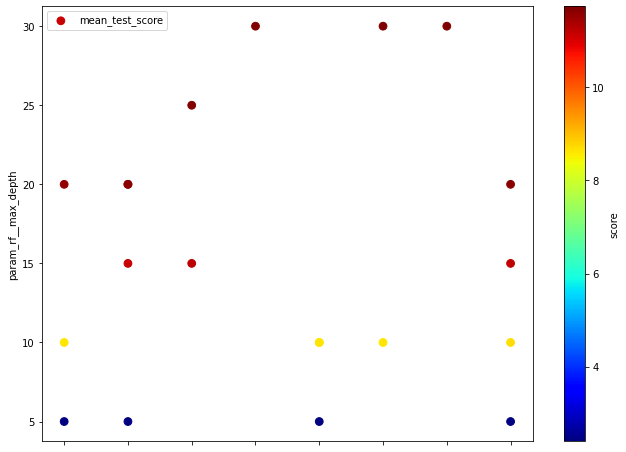

In [31]:
results = pd.DataFrame(pipeline_tuner.cv_results_)
results['score'] = np.exp(5 + (results['mean_test_score'] / 1e9))

# plot
results.plot(kind='scatter', x='param_rf__n_estimators', y='param_rf__max_depth',
             c='score', s=60, cmap=plt.get_cmap("jet"), colorbar=True, 
             label="mean_test_score", figsize=(11,8));

### Feature importances in a pipeline?

Getting feature importances is unfortunately very hacky... We have to manually reconstruct the features.

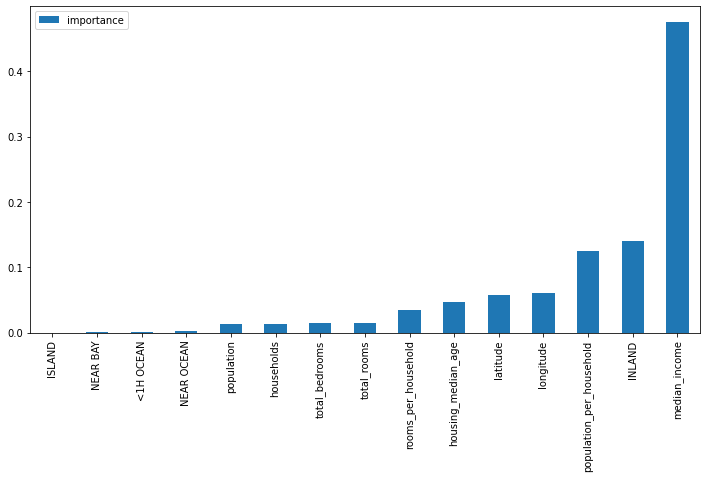

In [32]:
# Random forest feature importances
best_pipeline = pipeline_tuner.best_estimator_
best_model = best_pipeline['rf']
feature_importances = best_model.feature_importances_

num_pipeline = best_pipeline['preprocessing'].named_transformers_['num']
cat_pipeline = best_pipeline['preprocessing'].named_transformers_['cat']

# List of numerical and categorical features
num_features = num_attribs + ['rooms_per_household', 'population_per_household']
num_features += ['bedrooms_per_room'] if num_pipeline['feature_adder'].add_bedrooms_per_room else []
cat_ohe_features = list(*cat_pipeline['one_hot'].transformer.categories_)

# Combine everything to get all columns
attributes = num_features + cat_ohe_features
feature_importance_df = pd.DataFrame(feature_importances, index=attributes, columns=['importance'])
feature_importance_df.sort_values('importance').plot.bar(figsize=(12, 6));

### Evaluating on the test set

Note that the best pipeline obtained above will be used for inference without any modifications!

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

targets = strat_test_set['median_house_value']
preds = best_pipeline.predict(strat_test_set.drop('median_house_value', axis=1))

print('RMSE:', np.sqrt(mean_squared_error(targets, preds)))
print('MAPE:', mean_absolute_percentage_error(targets, preds))

RMSE: 48117.963048251186
MAPE: 0.18007928945089352


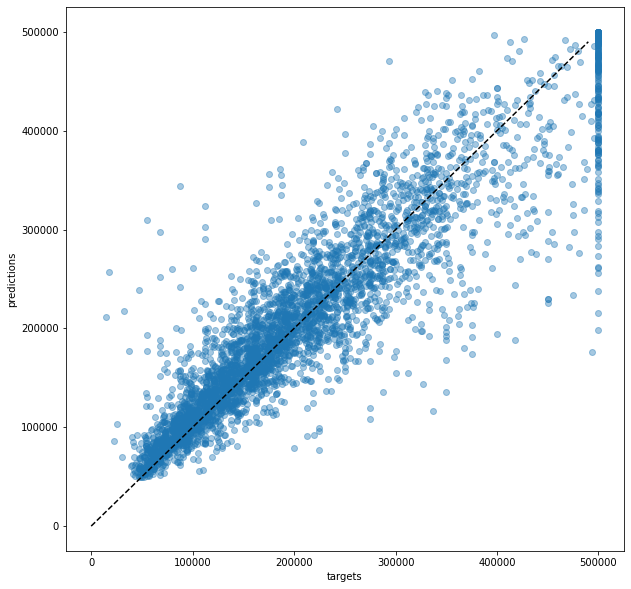

In [34]:
plt.figure(figsize=(10, 10))
plt.scatter(targets, preds, alpha=0.4);
plt.plot(range(0, 500000, 10000), range(0, 500000, 10000), 'k--')
plt.xlabel('targets')
plt.ylabel('predictions');

Let's try to compute for prices that were not clipped:

In [35]:
FILTER = targets < 400_000
targets_small = targets[FILTER]
housing_small = strat_test_set.loc[FILTER, :].drop('median_house_value', axis=1)
preds_small = best_pipeline.predict(housing_small)

print('RMSE:', np.sqrt(mean_squared_error(targets_small, preds_small)))
print('MAPE:', mean_absolute_percentage_error(targets_small, preds_small))

RMSE: 41478.18223344296
MAPE: 0.18289156175185736


Better RMSE! MAPE is worse since we have a smaller denominator in this subset. 

Finally, we calculate the [95% confidence interval](https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Confidence_Intervals/BS704_Confidence_Intervals_print.html) for the generalization error using `scipy.stats.t.interval`.

In [36]:
from scipy import stats

confidence = 0.95
squared_errors = (preds - targets)**2
m = len(squared_errors)

# confidence interval
np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([46071.98160832, 50080.42777881])

## Conclusion

Pipelines are **awesome**. We can define custom transformers using mixins, which we can then use as part of scikit-learn pipelines, which makes this technique very flexible. For example, even preprocessing can be included in a pipeline, and therefore be part of cross-validation.